## **1. Loading Dataset**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [27]:
# train_data = pd.read_csv('data/train.csv')
# test_data = pd.read_csv('data/test.csv')

train_data = pd.read_pickle("data/train.pkl")
test_data = pd.read_pickle("data/test.pkl")

In [28]:
X_train = np.vstack(train_data['data'].values)
y_train = train_data['labels'].values

X_test = np.vstack(test_data['data'].values)
y_test = test_data['labels'].values

In [29]:
X_train = X_train / 255.0
X_test = X_test  / 255.0

In [31]:
# Adding bias term to X
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [32]:
#One Hot Encoding Target Class
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

## **2. Logistic Regression Model**

In [100]:
class logistic_regression:
    def __init__(self, learning_rate=0.01, epochs=100):
    
        self.learning_rate = learning_rate
        self.epochs = epochs

        #Weight Initalization
        self.num_features = None
        self.num_classes = None
        self.weights = None

        # Initialize lists for tracking losses
        self.train_losses = []
        self.test_losses = []

    # Logistic Regression Functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict(self, X):
        y_pred = self.softmax(np.dot(X, self.weights))
        return np.argmax(y_pred, axis=1)
    
    def log_loss(self, y, y_pred, epsilon=1e-15):
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    
    def categorical_crossentropy(self, y, y_pred, epsilon=1e-15):
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def gradient_descent(self, X, y, weights, lr):
        y_pred = self.softmax(np.dot(X, weights))
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        return weights - lr * gradient


    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.num_features = X_train.shape[1]
        self.num_classes = y_train.shape[1]
        self.weights = np.random.randn(self.num_features, self.num_classes)
    
        for epoch in range(self.epochs):
            # Update Weights
            self.weights = self.gradient_descent(X_train, y_train, self.weights, self.learning_rate)

            train_pred = self.softmax(np.dot(X_train, self.weights))
            train_loss = self.categorical_crossentropy(y_train, train_pred)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = self.softmax(np.dot(X_test, self.weights))
                test_loss = self.categorical_crossentropy(y_test, test_pred)
                self.test_losses.append(test_loss)
            else:
                test_loss = None

            # if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{self.epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")


In [101]:
lr = logistic_regression(learning_rate=0.01, epochs=10000)

In [102]:
lr.fit(X_train, y_train, X_test, y_test)

Epoch 1/10000: Train Loss = 24.2679, Test Loss = 24.2318
Epoch 2/10000: Train Loss = 23.8149, Test Loss = 23.7933
Epoch 3/10000: Train Loss = 23.3817, Test Loss = 23.3693
Epoch 4/10000: Train Loss = 22.9631, Test Loss = 22.9559
Epoch 5/10000: Train Loss = 22.5610, Test Loss = 22.5614
Epoch 6/10000: Train Loss = 22.1793, Test Loss = 22.1836
Epoch 7/10000: Train Loss = 21.8186, Test Loss = 21.8258
Epoch 8/10000: Train Loss = 21.4804, Test Loss = 21.4909
Epoch 9/10000: Train Loss = 21.1622, Test Loss = 21.1737
Epoch 10/10000: Train Loss = 20.8616, Test Loss = 20.8718
Epoch 11/10000: Train Loss = 20.5770, Test Loss = 20.5843
Epoch 12/10000: Train Loss = 20.3054, Test Loss = 20.3112
Epoch 13/10000: Train Loss = 20.0458, Test Loss = 20.0497
Epoch 14/10000: Train Loss = 19.7978, Test Loss = 19.7992
Epoch 15/10000: Train Loss = 19.5612, Test Loss = 19.5585
Epoch 16/10000: Train Loss = 19.3367, Test Loss = 19.3298
Epoch 17/10000: Train Loss = 19.1257, Test Loss = 19.1156
Epoch 18/10000: Train L

## **3. Model Evaluation**

In [103]:
def confusion_matrix(y_true, y_pred):
    
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_true_indices = np.argmax(y_true, axis=1)
    
    for t, p in zip(y_true_indices, y_pred):
        cm[t, p] += 1
    
    return cm

def accuracy(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)  #Converting one-hot encoded back to label encoded
    return np.sum(y_true_label == y_pred) / len(y_true_label)


def precision(cm):
    
    precisions = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp > 0:
            precisions.append(tp / (tp + fp))
        else:
            precisions.append(0)
    return np.mean(precisions)

def recall(cm):
    
    recalls = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn > 0:
            recalls.append(tp / (tp + fn))
        else:
            recalls.append(0)
    return np.mean(recalls)

def f1_score(cm):
    
    precisions = precision(cm)
    recalls = recall(cm)
    
    if (precisions + recalls) > 0:
        return 2 * (precisions * recalls) / (precisions + recalls) 
    else:
        return 0

In [104]:
# Generate predictions for train and test sets
train_pred = lr.predict(X_train)


# Calculate training metrics
train_cm = confusion_matrix(y_train, train_pred)
train_accuracy = accuracy(y_train, train_pred)
train_precision = precision(train_cm)
train_recall = recall(train_cm)
train_f1 = f1_score(train_cm)

# Print Metrics
print("\nTraining Evaluation:")
print("Confusion Matrix:\n", train_cm)
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


test_pred = lr.predict(X_test)

test_cm = confusion_matrix(y_test, test_pred)
test_accuracy = accuracy(y_test, test_pred)
test_precision = precision(test_cm)
test_recall = recall(test_cm)
test_f1 = f1_score(test_cm)

print("\nValidation Evaluation:")
print("Confusion Matrix:\n", test_cm)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")



Training Evaluation:
Confusion Matrix:
 [[1487  331  369  320  273  304  166  384  979  387]
 [ 417 1412  262  403  264  300  311  317  470  844]
 [ 501  198  975  404  722  586  545  510  347  212]
 [ 311  369  522  899  462  840  581  420  289  307]
 [ 357  219  750  420 1020  456  696  689  208  185]
 [ 295  293  554  784  496 1103  527  425  299  224]
 [ 157  293  613  631  587  556 1292  400  204  267]
 [ 376  258  509  468  683  448  426 1180  271  381]
 [ 945  520  250  255  177  237  107  190 1672  647]
 [ 458  825  244  285  231  228  261  374  537 1557]]
Accuracy: 0.2519
Precision: 0.2515
Recall: 0.2519
F1 Score: 0.2517

Validation Evaluation:
Confusion Matrix:
 [[298  72  74  69  53  65  29  68 198  74]
 [ 90 265  51  88  59  57  68  50 101 171]
 [ 98  53 185  84 157 109 113  94  69  38]
 [ 53  61 122 180  95 167 118  64  52  88]
 [ 72  43 154  98 215  88 149 101  37  43]
 [ 63  64 109 150  95 232  98  82  68  39]
 [ 41  56 109 122 124 116 245  91  45  51]
 [ 79  62  94  83

# **4. Loss History**

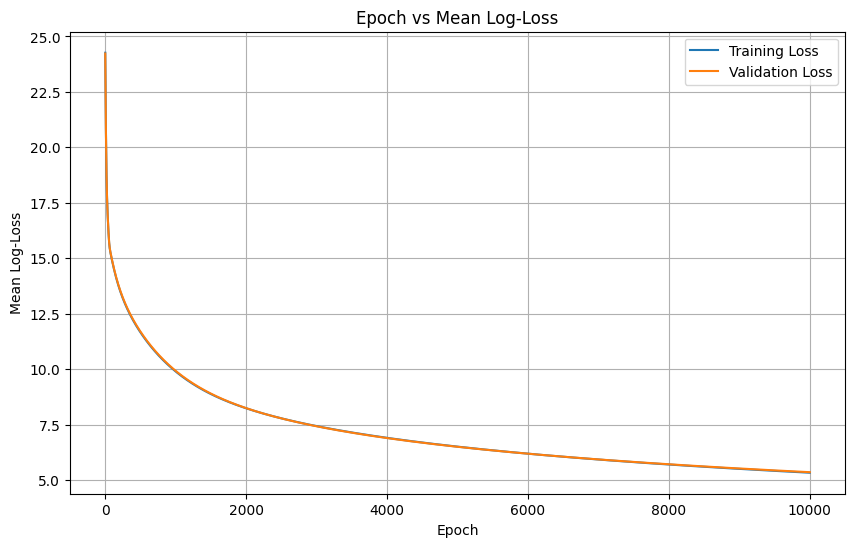

In [105]:
# Plot epoch vs log-loss
epochs = list(range(1, len(lr.train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr.train_losses, label='Training Loss')
plt.plot(epochs, lr.test_losses, label='Validation Loss')

plt.title('Epoch vs Mean Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Log-Loss')
plt.grid(True)
plt.legend()
plt.show()
